In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Lambda, Layer
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.objectives import binary_crossentropy
from keras import objectives
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
np.random.seed(123)

Using TensorFlow backend.


# Data

In [2]:
creditdata = pd.read_csv("https://raw.githubusercontent.com/gablum/datasets/master/creditdata.csv")
creditdata = creditdata.drop('Unnamed: 0', axis=1)
creditdata = creditdata.dropna(how='any')

In [3]:
print(creditdata.groupby('SeriousDlqin2yrs').size())

SeriousDlqin2yrs
0    111912
1      8357
dtype: int64


In [4]:
names = creditdata.columns
scaler = preprocessing.StandardScaler()
creditdata = scaler.fit_transform(creditdata)
creditdata = pd.DataFrame(creditdata, columns=names)

C:\Users\Gabriel\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gabriel\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [5]:
creditdata['SeriousDlqin2yrs'] = creditdata.SeriousDlqin2yrs.astype(int)
creditdata = creditdata.replace(3, 1)

In [6]:
baddata = creditdata[(creditdata.iloc[:,0] == 1)]
baddata = baddata.drop(baddata.columns[[0]], axis=1)

# First model

In [7]:
feature_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
X = creditdata[feature_cols]
y = creditdata.SeriousDlqin2yrs

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [9]:
model = Sequential()

model.add(Dense(10, kernel_regularizer=l2(0.01), activation='relu', input_dim = 10))
model.add(Dense(16, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(8, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=Adam(lr = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(x = X_train, y = y_train,
          validation_data=[X_test, y_test],
          epochs = 4,
          batch_size=20)

Train on 72161 samples, validate on 48108 samples
Epoch 1/4
72161/72161 [==============================] - 10s 144us/step - loss: 0.5832 - acc: 0.8931 - val_loss: 0.3635 - val_acc: 0.9304
Epoch 2/4
72161/72161 [==============================] - 8s 106us/step - loss: 0.3176 - acc: 0.9306 - val_loss: 0.2905 - val_acc: 0.9306
Epoch 3/4
72161/72161 [==============================] - 8s 113us/step - loss: 0.2770 - acc: 0.9307 - val_loss: 0.2673 - val_acc: 0.9304
Epoch 4/4
72161/72161 [==============================] - 11s 151us/step - loss: 0.2613 - acc: 0.9306 - val_loss: 0.2574 - val_acc: 0.9304


In [13]:
nn_pred = model.predict(X_test)
print('AUC: ', metrics.roc_auc_score(y_test, nn_pred))

AUC:  0.7502266110524116


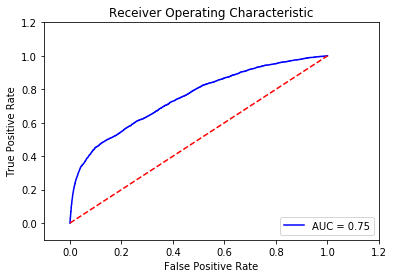

In [14]:
actual = y_test
predictions = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Second model: SMOTE

In [15]:
np.bincount(y)

array([111912,   8357], dtype=int64)

In [16]:
X_smote, y_smote = SMOTE(random_state=12, ratio = 1.0).fit_sample(X, y)

In [17]:
np.bincount(y_smote)

array([111912, 111912], dtype=int64)

In [18]:
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)

In [19]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_smote, y_smote, test_size = 0.4, random_state = 0)

In [20]:
model.fit(x = X_train1, y = y_train1,
          validation_data=[X_test, y_test],
          epochs = 4,
          batch_size=20)

Train on 134294 samples, validate on 48108 samples
Epoch 1/4
134294/134294 [==============================] - 29s 214us/step - loss: 0.6579 - acc: 0.6790 - val_loss: 0.5879 - val_acc: 0.7925
Epoch 2/4
134294/134294 [==============================] - 25s 183us/step - loss: 0.6101 - acc: 0.7227 - val_loss: 0.5764 - val_acc: 0.8252
Epoch 3/4
134294/134294 [==============================] - 20s 150us/step - loss: 0.6008 - acc: 0.7286 - val_loss: 0.5711 - val_acc: 0.8379
Epoch 4/4
134294/134294 [==============================] - 23s 172us/step - loss: 0.5959 - acc: 0.7304 - val_loss: 0.5804 - val_acc: 0.8185


In [21]:
nn_pred = model.predict(X_test1)
print('AUC: ', metrics.roc_auc_score(y_test1, nn_pred))

AUC:  0.8048810733863294


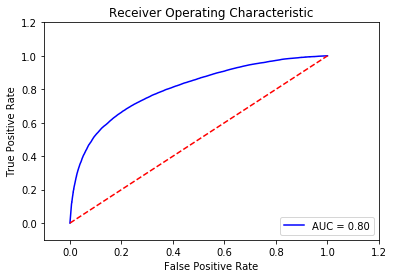

In [22]:
actual = y_test1
predictions = model.predict(X_test1)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Third model: Variational Autoencoder

### create and train the variational autoencoder

In [23]:
hiddendim = 8
latentdim = 6

In [24]:
# build encoder (first step)
inputs = Input(shape=(10, ), name='encoder_input')
x = Dense(hiddendim, activation='relu')(inputs)
z_mean = Dense(latentdim, name='z_mean')(x)
z_sd = Dense(latentdim, name='z_sd')(x)

In [25]:
# reparametrization trick
def sampling(args):
    z_mean, z_sd = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + K.square(z_sd) * epsilon

In [26]:
# layer object z
z = Lambda(sampling, output_shape=(latentdim,), name='z')([z_mean, z_sd])

In [27]:
# build encoder (second step)
encoder = Model(inputs, [z_mean, z_sd, z], name='encoder')

In [28]:
# build decoder (first step)
latent_inputs = Input(shape=(latentdim,), name='z_sampling')
x = Dense(hiddendim, activation='relu')(latent_inputs)
outputs = Dense(10, activation='tanh')(x)

In [29]:
# build decoder (second step)
decoder = Model(latent_inputs, outputs, name='decoder')

In [30]:
# build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_model')

In [31]:
#define loss function
reconstruction_loss = mse(inputs, outputs)
kl_loss = (K.square(z_mean) + K.square(z_sd) - K.log(K.square(z_sd)) - 1)/2
kl_loss = K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [32]:
vae.compile(optimizer='adam')

In [33]:
vae.fit(baddata, epochs=5, batch_size=6, validation_data=(baddata, None))

Train on 8357 samples, validate on 8357 samples
Epoch 1/5
8357/8357 [==============================] - 6s 763us/step - loss: 9.3424 - val_loss: 8.3752
Epoch 2/5
8357/8357 [==============================] - 6s 703us/step - loss: 8.0286 - val_loss: 7.7121
Epoch 3/5
8357/8357 [==============================] - 5s 563us/step - loss: 7.5298 - val_loss: 7.3149
Epoch 4/5
8357/8357 [==============================] - 6s 680us/step - loss: 7.0407 - val_loss: 6.8930
Epoch 5/5
8357/8357 [==============================] - 5s 608us/step - loss: 6.8307 - val_loss: 6.6799


### generate synthetic data of the minority class and add it to creditdata

In [34]:
mean = [0,0,0,0,0,0]
cov = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]

In [35]:
nd = 103555

In [36]:
syntheticdata = pd.DataFrame.from_records(decoder.predict(np.random.multivariate_normal(mean,cov,nd)))

In [37]:
syntheticdata.insert(loc=0, column='blub', value=[1]*nd)
syntheticdata = syntheticdata.values
syntheticdata = pd.DataFrame(syntheticdata)
syntheticdata = syntheticdata.rename(index=str, columns={0: "SeriousDlqin2yrs", 1: "RevolvingUtilizationOfUnsecuredLines", 2: "age", 3: "NumberOfTime30-59DaysPastDueNotWorse", 4: "DebtRatio", 5: "MonthlyIncome", 6: "NumberOfOpenCreditLinesAndLoans", 7: "NumberOfTimes90DaysLate", 8: "NumberRealEstateLoansOrLines", 9: "NumberOfTime60-89DaysPastDueNotWorse", 10: "NumberOfDependents"})
syntheticdata['SeriousDlqin2yrs'] = syntheticdata.SeriousDlqin2yrs.astype(int)

In [38]:
bigdata = pd.concat([creditdata, syntheticdata], ignore_index=True, sort=False)

In [39]:
print(bigdata.groupby('SeriousDlqin2yrs').size())

SeriousDlqin2yrs
0    111912
1    111912
dtype: int64


### train model with augmented dataset

In [40]:
feature_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
X = bigdata[feature_cols]
y = bigdata.SeriousDlqin2yrs

In [41]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [42]:
model.fit(x = X_train2, y = y_train2,
          validation_data=[X_test, y_test],
          epochs = 4,
          batch_size=20)

Train on 134294 samples, validate on 48108 samples
Epoch 1/4
134294/134294 [==============================] - 22s 164us/step - loss: 0.3069 - acc: 0.9327 - val_loss: 0.3700 - val_acc: 0.9049
Epoch 2/4
134294/134294 [==============================] - 21s 160us/step - loss: 0.2894 - acc: 0.9359 - val_loss: 0.3666 - val_acc: 0.9043
Epoch 3/4
134294/134294 [==============================] - 28s 205us/step - loss: 0.2830 - acc: 0.9363 - val_loss: 0.3519 - val_acc: 0.9087
Epoch 4/4
134294/134294 [==============================] - 29s 218us/step - loss: 0.2782 - acc: 0.9365 - val_loss: 0.3539 - val_acc: 0.9074


In [43]:
nn_pred = model.predict(X_test)
print('AUC: ', metrics.roc_auc_score(y_test, nn_pred))

AUC:  0.8101516651859857


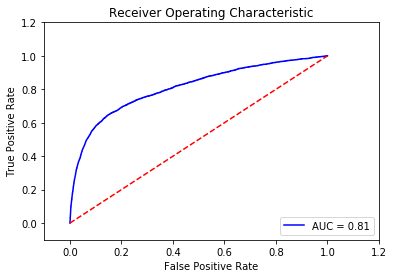

In [44]:
actual = y_test
predictions = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Fourth model: Generative Adversial Network

### Build Models

In [45]:
# make latent samples from normal distribution
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [46]:
# make sure that the discriminator will be fixed during training
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [47]:
def make_GAN(sample_size, 
             g_hidden_size, 
             d_hidden_size, 
             g_learning_rate,
             d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        Activation('relu'),
        Dense(10),        
        Activation('sigmoid')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(10,)),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [48]:
# make labels for the batch size and the test size
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

### Training

In [49]:
# Hyperparameters
sample_size     = 100    # latent sample size
g_hidden_size   = 6
d_hidden_size   = 6
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.0001   # learning rate for the discriminator

epochs          = 200
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1     # smoothing

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

gan, generator, discriminator = make_GAN(
    sample_size,
    g_hidden_size,
    d_hidden_size,
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(baddata.values)//batch_size):
        # Real data (minority class)
        X_batch_real = baddata.values[i*batch_size:(i+1)*batch_size]

        # Latent samples
        latent_samples = make_latent_samples(batch_size, sample_size)
        # Fake data (on minibatches)
        X_batch_fake = generator.predict_on_batch(latent_samples)

        # Train the discriminator
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # Train the generator (the discriminator is fixed)
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)

    # Evaluate
    X_eval_real = baddata.values[np.random.choice(len(baddata.values), eval_size, replace=False)]

    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real)

    losses.append((d_loss, g_loss))

    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

C:\Users\Gabriel\Anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/200 Discriminator Loss: 1.6785 Generator Loss: 0.4358
Epoch:   2/200 Discriminator Loss: 1.5942 Generator Loss: 0.4781
Epoch:   3/200 Discriminator Loss: 1.6571 Generator Loss: 0.4110
Epoch:   4/200 Discriminator Loss: 1.6889 Generator Loss: 0.3946
Epoch:   5/200 Discriminator Loss: 1.6044 Generator Loss: 0.4187
Epoch:   6/200 Discriminator Loss: 1.6849 Generator Loss: 0.3839
Epoch:   7/200 Discriminator Loss: 1.5691 Generator Loss: 0.4363
Epoch:   8/200 Discriminator Loss: 1.4572 Generator Loss: 0.4335
Epoch:   9/200 Discriminator Loss: 1.6257 Generator Loss: 0.3978
Epoch:  10/200 Discriminator Loss: 1.5167 Generator Loss: 0.4289
Epoch:  11/200 Discriminator Loss: 1.6222 Generator Loss: 0.4102
Epoch:  12/200 Discriminator Loss: 1.5324 Generator Loss: 0.4224
Epoch:  13/200 Discriminator Loss: 1.5836 Generator Loss: 0.4112
Epoch:  14/200 Discriminator Loss: 1.4244 Generator Loss: 0.4033
Epoch:  15/200 Discriminator Loss: 1.4904 Generator Loss: 0.4420
Epoch:  16/200 Discrimina

Epoch: 128/200 Discriminator Loss: 0.7609 Generator Loss: 0.7611
Epoch: 129/200 Discriminator Loss: 0.7930 Generator Loss: 0.7675
Epoch: 130/200 Discriminator Loss: 0.7647 Generator Loss: 0.7622
Epoch: 131/200 Discriminator Loss: 0.7500 Generator Loss: 0.7713
Epoch: 132/200 Discriminator Loss: 0.7951 Generator Loss: 0.7868
Epoch: 133/200 Discriminator Loss: 0.7303 Generator Loss: 0.7871
Epoch: 134/200 Discriminator Loss: 0.8268 Generator Loss: 0.7971
Epoch: 135/200 Discriminator Loss: 0.6861 Generator Loss: 0.8440
Epoch: 136/200 Discriminator Loss: 0.7154 Generator Loss: 0.8085
Epoch: 137/200 Discriminator Loss: 0.7565 Generator Loss: 0.8111
Epoch: 138/200 Discriminator Loss: 0.7702 Generator Loss: 0.7952
Epoch: 139/200 Discriminator Loss: 0.8500 Generator Loss: 0.7765
Epoch: 140/200 Discriminator Loss: 0.7705 Generator Loss: 0.8239
Epoch: 141/200 Discriminator Loss: 0.7403 Generator Loss: 0.7832
Epoch: 142/200 Discriminator Loss: 0.7451 Generator Loss: 0.7865
Epoch: 143/200 Discrimina

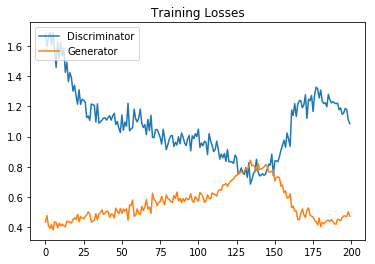

In [50]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend(loc='upper left')
plt.show()

### Generate synthetic data with GAN

In [51]:
# Generate data to fill baddata
latent_samples = make_latent_samples(103555, sample_size) 

generated_data = generator.predict(latent_samples)
generated_data = pd.DataFrame(generated_data)

In [52]:
synthetic_data = generated_data.rename(index=str, columns={0: "RevolvingUtilizationOfUnsecuredLines", 1: "age", 2: "NumberOfTime30-59DaysPastDueNotWorse", 3: "DebtRatio", 4: "MonthlyIncome", 5: "NumberOfOpenCreditLinesAndLoans", 6: "NumberOfTimes90DaysLate", 7: "NumberRealEstateLoansOrLines", 8: "NumberOfTime60-89DaysPastDueNotWorse", 9: "NumberOfDependents"})
synthetic_data.insert(loc=0, column='SeriousDlqin2yrs', value=1)

### Add synthetized data to the original dataset

In [53]:
new_data = pd.concat([creditdata, synthetic_data], ignore_index=True)
new_data['SeriousDlqin2yrs'].groupby(new_data['SeriousDlqin2yrs']).count()

SeriousDlqin2yrs
0    111912
1    111912
Name: SeriousDlqin2yrs, dtype: int64

### Train NN with new data

In [54]:
X_new = new_data[feature_cols]
y_new = new_data.SeriousDlqin2yrs

In [55]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_new, y_new, test_size = 0.4, random_state = 0)

In [56]:
model = Sequential()

model.add(Dense(10, kernel_regularizer=l2(0.01), activation='relu', input_dim = 10))
model.add(Dense(16, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(8, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.compile(optimizer=Adam(lr = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
model.fit(x = X_train3, y = y_train3,
          validation_data=[X_test, y_test],
          epochs = 4,
          batch_size= 20)

Train on 134294 samples, validate on 48108 samples
Epoch 1/4
134294/134294 [==============================] - 29s 213us/step - loss: 0.6191 - acc: 0.8849 - val_loss: 0.3223 - val_acc: 0.9314
Epoch 2/4
134294/134294 [==============================] - 29s 217us/step - loss: 0.3504 - acc: 0.9637 - val_loss: 0.2748 - val_acc: 0.9326
Epoch 3/4
134294/134294 [==============================] - 29s 219us/step - loss: 0.2687 - acc: 0.9639 - val_loss: 0.2640 - val_acc: 0.9327
Epoch 4/4
134294/134294 [==============================] - 30s 222us/step - loss: 0.2266 - acc: 0.9640 - val_loss: 0.2609 - val_acc: 0.9322


In [60]:
nn_pred = model.predict(X_test)
print('AUC: ', metrics.roc_auc_score(y_test, nn_pred))

AUC:  0.8007064836809772


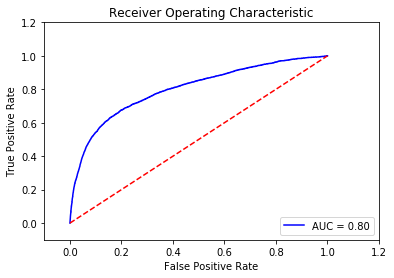

In [61]:
actual = y_test
predictions = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()